###**Advanced Machine Learning - Edoardo Giuili** 

# **Gene expression analysis for colorectal cancer prediction**
The dataset can be found at the following site: https://sbcb.inf.ufrgs.br/cumida

## **Description of the DataSet**
The Curated Microarray Database (CuMiDa) is a repository containing  several cancer microarray datasets. CuMiDa offers new, manually and carefully curated datasets (*Feltes, B.C.; et al. CuMiDa: An Extensively Curated Microarray Database for Benchmarking and Testing of Machine Learning Approaches in Cancer Research. Journal of Computational Biology, 2019*). 
In my case, the dataset contains 105 rows/samples (patients) and 22280 columns: 2 columns represent the sample id and the categorical value (tumoral or normal) while the other columns represent the expression of 22278 different genes. 
The aim of this project is to design one or more machine learning methods that are able to make accurate predictions on new unknown examples.

# **Data preprocessing**

## *Step 1 - Import the Libraries*



In [2]:
# Import General Libraries
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Import Libraries for Classification
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA as sklearnPCA
from mpl_toolkits.mplot3d import Axes3D
import sklearn.metrics 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Import Libraries for Deep Learning
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.random import set_seed
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier


## *Step 2 - Load Data and process it*



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Colorectal_GSE44861.csv to Colorectal_GSE44861.csv


In [3]:
entire_ds = pd.read_csv("drive/MyDrive/Colorectal_GSE44861.csv")
print(entire_ds.shape)
entire_ds.head(10)

(105, 22279)


,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,1438_at,1487_at,1494_f_at,1598_g_at,160020_at,1729_at,1773_at,177_at,179_at,1861_at,200000_s_at,200001_at,200002_at,200003_s_at,200004_at,200005_at,200006_at,200007_at,200008_s_at,200009_at,200010_at,200011_s_at,200012_x_at,200013_at,200014_s_at,200015_s_at,200016_x_at,200017_at,...,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-LysX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-r2-Bs-dap-3_at,AFFX-r2-Bs-dap-5_at,AFFX-r2-Bs-dap-M_at,AFFX-r2-Bs-lys-3_at,AFFX-r2-Bs-lys-5_at,AFFX-r2-Bs-lys-M_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-phe-M_at,AFFX-r2-Bs-thr-3_s_at,AFFX-r2-Bs-thr-5_s_at,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,909,normal,11.603630,6.161494,5.586689,7.665427,5.181192,9.328589,5.667076,5.825957,7.684897,5.280453,5.924691,9.171197,5.892172,10.675036,7.130390,8.365860,5.777034,7.294819,7.452211,7.183493,10.563175,11.694286,11.793642,14.133192,13.253494,11.688668,12.730797,13.111323,10.624835,13.324794,13.509437,11.613050,14.513084,13.557289,11.010666,12.461846,13.717629,14.266796,...,7.421438,12.472236,12.823305,11.611549,5.473242,5.038363,5.336605,5.434170,12.581952,10.383143,5.850063,5.218544,4.953496,4.927370,5.013688,4.972475,5.332326,5.216208,4.976444,5.588318,5.116983,5.207860,5.128672,5.333412,5.202440,9.222836,8.555462,8.541967,9.949472,10.225310,12.825918,12.744079,14.633211,14.077696,5.493690,5.129016,5.013772,4.964384,5.012729,5.032029
1,911,normal,10.724242,6.168925,5.645848,8.285704,5.270711,8.892988,6.484289,5.596518,7.735154,5.680837,5.373245,9.374720,6.469610,10.410668,7.434784,8.037932,5.692502,7.650652,8.252928,6.130473,9.415151,9.691296,10.760481,13.053457,12.786984,10.893364,11.531514,12.790593,7.645248,12.030956,12.254362,10.844536,14.126348,12.373588,10.444607,12.200934,13.551583,13.896925,...,6.336246,12.044913,13.853550,12.724685,5.728112,5.380797,5.343777,5.905650,12.531953,11.676500,6.545668,5.276944,5.160995,5.000274,5.093408,5.191535,5.537860,5.232726,5.146406,5.845758,6.267728,5.106717,5.253862,5.393300,5.259405,11.920945,11.540363,11.581186,12.507296,12.877094,14.610437,14.852044,15.309681,15.190121,5.535807,5.063369,5.103648,5.089872,5.156410,5.270410
2,913,normal,9.897182,6.141052,6.028690,7.382975,5.241439,8.906832,6.253771,5.728508,8.553831,5.306472,5.497906,8.239426,5.861003,10.149764,7.203162,8.205351,5.767240,6.306600,7.136410,6.118094,10.557734,9.942647,12.476845,14.577318,12.884134,11.877103,13.159349,13.158277,8.516653,12.981577,13.543751,10.236101,14.826589,13.889126,11.686800,12.700132,14.270469,14.620751,...,6.072724,12.921625,13.395459,12.750573,5.588481,5.231683,5.432931,5.697047,12.539151,10.797103,6.130881,5.343271,5.036490,5.092366,5.098212,5.090961,5.207550,4.967397,5.024144,5.471654,5.447919,5.363319,5.487234,5.585319,5.145920,10.562255,10.171149,10.124445,11.320522,11.639455,13.795802,14.016776,15.093576,14.821565,5.406839,5.186247,5.113486,5.021668,5.170374,5.031002
3,916,normal,10.177590,6.547922,5.657623,8.108889,5.309596,9.694124,6.511937,5.666979,7.737384,5.845548,5.902324,8.407829,6.315867,10.328124,7.244356,8.320469,6.045240,6.019156,7.755093,6.218387,10.711764,10.561821,12.321879,14.567547,12.159402,12.169462,12.772461,12.678296,8.753287,12.975418,13.677728,10.650770,14.813610,13.609111,11.203525,12.341656,14.170792,14.321302,...,6.035609,12.967256,13.918037,13.399531,5.883299,5.174830,5.548479,6.323225,14.013843,11.683140,6.000761,5.408122,5.129871,5.250453,5.101656,5.185830,5.422394,5.195827,5.009103,6.256389,6.254604,5.279590,5.314941,5.717720,5.4

In [4]:
#replace categorical labels with 0 (for normal) and 1 (for tumoral)
entire_ds["type"] = entire_ds["type"].replace("tumoral",1)
entire_ds["type"] = entire_ds["type"].replace("normal",0)

In [5]:
#save the cols "samples" and "type"
samples_col = entire_ds["samples"]
type_col = entire_ds["type"]

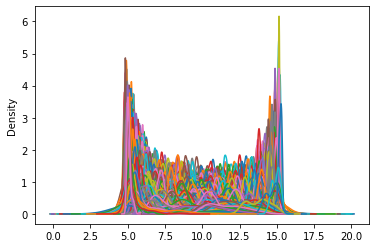

In [83]:
#let's plot the distribution of the genes' expressions
data = entire_ds.drop(columns=["samples","type"])
data.plot(kind="kde",legend=None)

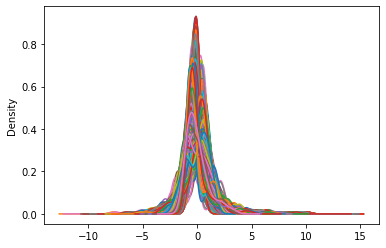

In [84]:
#standardize the distribution of data
scaler = preprocessing.StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
data.plot(kind="kde",legend=None)

In [8]:
#merge the type and samples cols again with the standardized dataset (data)
lab = pd.DataFrame(type_col)
sample = pd.DataFrame(samples_col)
stand_dataset = pd.concat([sample,lab,data],axis=1)
stand_dataset.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,1438_at,1487_at,1494_f_at,1598_g_at,160020_at,1729_at,1773_at,177_at,179_at,1861_at,200000_s_at,200001_at,200002_at,200003_s_at,200004_at,200005_at,200006_at,200007_at,200008_s_at,200009_at,200010_at,200011_s_at,200012_x_at,200013_at,200014_s_at,200015_s_at,200016_x_at,200017_at,...,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-LysX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-r2-Bs-dap-3_at,AFFX-r2-Bs-dap-5_at,AFFX-r2-Bs-dap-M_at,AFFX-r2-Bs-lys-3_at,AFFX-r2-Bs-lys-5_at,AFFX-r2-Bs-lys-M_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-phe-M_at,AFFX-r2-Bs-thr-3_s_at,AFFX-r2-Bs-thr-5_s_at,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,909,0,1.179505,-1.071123,-0.689799,-0.201807,-0.550619,1.261573,-0.557836,0.987395,-0.251630,-0.448654,-0.423422,0.779346,-0.236636,0.273873,-0.481050,0.392672,-0.182818,1.528535,-0.263488,1.071036,0.237507,0.391959,-0.912532,-0.087001,1.102235,-0.146565,-0.277405,0.517323,0.572566,0.889964,0.038363,0.876542,-1.199022,-0.270913,-0.526010,-0.007375,-1.778782,-0.281974,...,0.335993,0.910172,0.726863,0.439371,-0.567516,-0.803600,-0.613926,-0.675474,0.898242,-0.200765,-0.692660,-0.587147,-0.579955,-0.666977,-0.494394,-0.638962,-0.287775,-0.179841,-0.644304,-0.520390,-0.790429,-0.502517,-0.674803,-0.615106,-0.612561,-1.156334,-1.250666,-1.239753,-1.191231,-1.181558,-1.236757,-1.384235,-1.209523,-1.496987,-0.548397,-0.549971,-0.588422,-0.708152,-0.779673,-0.412636
1,911,0,0.061814,-1.059531,-0.586830,1.456859,0.033475,0.503819,1.336078,-0.463019,-0.207974,0.013761,-0.971296,1.118277,0.641395,-0.078916,0.179939,-0.676124,-0.572852,2.285947,1.837519,-1.043856,-1.471882,-1.081876,-2.819705,-2.171712,0.027674,-1.992556,-3.829399,-0.618537,-1.270501,-1.203297,-3.001717,-0.028264,-4.014765,-3.359210,-1.854039,-0.856147,-2.667571,-2.435561,...,-0.751214,0.453951,1.647555,1.691231,-0.312193,0.235871,-0.600806,0.430509,0.843638,2.130498,0.287404,-0.443827,-0.271844,-0.640163,-0.423494,-0.525965,0.027606,-0.138884,-0.367287,-0.227139,1.470494,-0.636537,-0.596707,-0.505331,-0.539163,1.038967,1.094885,1.076155,1.067635,1.086288,1.190251,1.377466,1.391268,1.265896,-0.518303,-0.742907,-0.452413,0.377902,0.202331,1.406936
2,913,0,-0.989371,-1.103013,0.079531,-0.957104,-0.157519,0.527901,0.801846,0.371366,0.503178,-0.418605,-0.847442,-0.772353,-0.284031,-0.427081,-0.323026,-0.130464,-0.228005,-0.574945,-1.092119,-1.068719,0.229405,-0.896927,0.348633,0.770500,0.251451,0.290814,0.991865,0.683608,-0.731481,0.334684,0.121480,-0.744602,1.083549,0.594854,1.060266,0.767792,1.180392,1.778936,...,-1.015225,1.389950,1.238176,1.720345,-0.452073,-0.216771,-0.437705,-0.058825,0.851499,0.545394,-0.297005,-0.281055,-0.456719,-0.606290,-0.419221,-0.577844,-0.479238,-0.796770,-0.566558,-0.653283,-0.140223,-0.296526,-0.451127,-0.153356,-0.685385,-0.066524,0.018949,-0.033893,0.019570,0.027841,0.082320,0.283160,0.560421,0.350529,-0.610454,-0.381770,-0.437525,-0.212382,0.297764,-0.420473
3,916,0,-0.632976,-0.468287,-0.566334,0.984043,0.287189,1.897444,1.400152,-0.017594,-0.206037,0.203992,-0.445644,-0.491909,0.407620,-0.189067,-0.233575,0.244731,1.054694,-1.186786,0.531246,-0.867288,0.458753,-0.441328,0.062572,0.751635,-1.417898,0.969413,-0.154005,-1.016233,-0.585108,0.324721,0.446003,-0.256394,0.989052,-0.135710,-0.073544,-0.398364,0.646852,0.035388,...,-1.052410,1.438667,1.705184,2.450179,-0.156731,-0.389350,-0.226317,1.410044,2.462007,2.142467,-0.480336,-0.121906,-0.318059,-0.548145,-0.416158,-0.528908,-0.149570,-0.230375,-0.591074,0.240

In [ ]:
data.shape
entire_ds.shape
#data[1:]

(105, 22279)

## *Step 3 - PCA*
Looking at the variability present in my dataset is a good practise before starting the machine learning analysis. In particular, using PCA could be worth and give some more information about the data variability.

[]

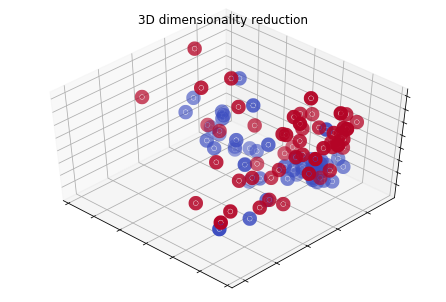

In [79]:
#study the dataset variability with PCA
pca = sklearnPCA(n_components=3)
X_reduced  = pca.fit_transform(data)
Y=lab
plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=48, azim=134,)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,cmap=plt.cm.coolwarm,linewidths=10)
ax.set_title("3D dimensionality reduction")
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

PCA doesn't seem to find 3 main PCs that are able to separate the two classes of data (Tumoral vs Normal). For this reason, I have to check how many components are necessary to explain at least the 95% of variability.

In [80]:
#find the number of components necessary to explain 95% of data variability
pcaComponents = sklearnPCA(n_components=0.95)
reduced  = pcaComponents.fit_transform(data)
print(reduced.shape)

(105, 73)


The number of components necessary to explain 95% of the variability in the dataset is 73.

In [81]:
d = {0:0}
for i in range(5,100,5):
  pcaComponents = sklearnPCA(n_components=i/100)
  reduced = pcaComponents.fit_transform(data)
  d[reduced.shape[1]]=i

(0.0, 80.0)

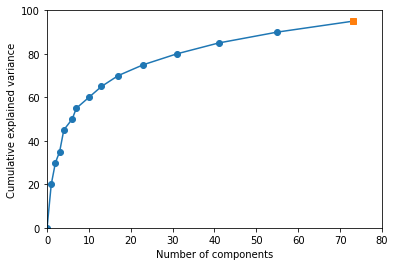

In [82]:
lists = d.items()
x_axis,y_axis = zip(*lists)
plt.plot(x_axis,y_axis,"-o")
plt.ylabel("Cumulative explained variance")
plt.xlabel("Number of components")
x0 = [73]
y0 = [95]
plt.plot(x0,y0,"s")
plt.ylim((0,100))
plt.xlim((0,80))

# **Solving the Classification problem**
Firstly I have to split my dataset into a training set and a test set.

In [9]:
#split the dataset
train,test = train_test_split(stand_dataset,test_size=0.2,random_state=10)
train_y = train.type
train_x = train.drop(columns= ["type","samples"])
test_y = test.type
test_x = test.drop(columns= ["type","samples"])

In [ ]:
print(train["type"].value_counts())

1    44
0    40
Name: type, dtype: int64


The classes in the training set are slightly unbalanced. For this reason, I use the SMOTE library, which uses a nearest neighbors algorithm to generate new and synthetic data.

In [10]:
oversample = SMOTE(random_state=12)
train_x,train_y = oversample.fit_resample(train_x,train_y)
test_x,test_y = oversample.fit_resample(test_x,test_y)

In [ ]:
test_y.value_counts()

1    13
0    13
Name: type, dtype: int64

## *Classifier 1 - Logistic Regression*

In [11]:
folds = [2,4,6,8,10]
seed = 7
model = LogisticRegression()
results = []
scoring_list = ["accuracy","roc_auc"]
for fold in folds:
  print("\nResults of %s-fold cross-validation"%fold)
  kfold = KFold(n_splits=fold, random_state=seed,shuffle=True)
  for scoring in scoring_list:
    cv_results = cross_val_score(model, train_x, train_y.ravel(), cv=kfold, scoring=scoring)
    results.append(cv_results)
    print(scoring+": "+str(round(cv_results.mean(),3))+" +/- "+str(round(cv_results.std(),3)))


Results of 2-fold cross-validation
accuracy: 0.875 +/- 0.034
roc_auc: 0.857 +/- 0.039

Results of 4-fold cross-validation
accuracy: 0.852 +/- 0.059
roc_auc: 0.879 +/- 0.053

Results of 6-fold cross-validation
accuracy: 0.842 +/- 0.082
roc_auc: 0.865 +/- 0.1

Results of 8-fold cross-validation
accuracy: 0.852 +/- 0.063
roc_auc: 0.891 +/- 0.096

Results of 10-fold cross-validation
accuracy: 0.854 +/- 0.1
roc_auc: 0.871 +/- 0.152


Logistic regression seems to perform quite good for both accuracy and roc_auc. However, I can perform the tuning of the algorithm, also called hyperparameter optimization. One approach to perform this task is the Grid Search approach, which will build and evaluate a model for each combination of hyperparameters specified in a grid. The dual is set to True since the number of features >> number of examples.

In [12]:
#Grid Search
hyperpar = {"C":[1e-10, 1e-8, 1e-6, 1e-4,1e-2,1e-1,1,10,100]}
grid = GridSearchCV(estimator=LogisticRegression(dual=True,solver="liblinear",random_state = 7),param_grid=hyperpar,scoring="accuracy")
grid.fit(train_x,train_y.ravel())
best_accuracy = grid.best_score_
best_hyperp = grid.best_params_
print("Best CV accuracy: ",best_accuracy)
print("Best Params: ",best_hyperp)

Best CV accuracy:  0.8633986928104577
Best Params:  {'C': 1e-10}


In [15]:
#Make predictions on the test set
predictions = grid.predict(test_x)
acc_logregr = sklearn.metrics.accuracy_score(test_y.ravel(), predictions)
auc_logregr = sklearn.metrics.roc_auc_score(test_y.ravel(), predictions)
print("Accuracy on Test Set: ",acc_logregr)
print("AUC: ",auc_logregr)

Accuracy on Test Set:  0.8461538461538461
AUC:  0.8461538461538461


In [16]:
final_results = {}
final_results["LogRegr"] = {"AUC":auc_logregr,"ACC":acc_logregr}

{'LogRegr': {'ACC': 0.8461538461538461, 'AUC': 0.8461538461538461}}

Even tuning the hyperparameter C, no great improvement has been reached with the Grid Search approach. The reason can be due to the fact that there are no features (since the PCA failed in separating data in 3D space) that can explain an high percentage of variability, meaning that there is no feature associated with high weight. Thus, a simple linear logistic regression may not be able to correctly make the classification.

## *Classifier 2 - Naive Bayes (NB)*

In [ ]:
#Perform the cross-validation procedure
folds = [2,4,6,8,10]
seed = 7
model = GaussianNB()
results = []
scoring_list = ["accuracy","roc_auc"]
for fold in folds:
  print("\nResults of %s-fold cross-validation"%fold)
  kfold = KFold(n_splits=fold, random_state=seed,shuffle=True)
  for scoring in scoring_list:
    cv_results = cross_val_score(model, train_x, train_y.ravel(), cv=kfold, scoring=scoring)
    results.append(cv_results)
    print(scoring+": "+str(round(cv_results.mean(),3))+" +/- "+str(round(cv_results.std(),3)))


Results of 2-fold cross-validation
accuracy: 0.852 +/- 0.034
roc_auc: 0.847 +/- 0.03

Results of 4-fold cross-validation
accuracy: 0.864 +/- 0.079
roc_auc: 0.877 +/- 0.083

Results of 6-fold cross-validation
accuracy: 0.818 +/- 0.121
roc_auc: 0.848 +/- 0.119

Results of 8-fold cross-validation
accuracy: 0.83 +/- 0.084
roc_auc: 0.851 +/- 0.102

Results of 10-fold cross-validation
accuracy: 0.854 +/- 0.111
roc_auc: 0.867 +/- 0.112


On the cross validation procedure, the NB performs similar to Linear Regression.

In [19]:
#Perform the prediction on the test set
model = GaussianNB()
model.fit(train_x,train_y.ravel())

GaussianNB()

In [20]:
predictions = model.predict(test_x)
acc_nb = sklearn.metrics.accuracy_score(test_y.ravel(), predictions)
auc_nb = sklearn.metrics.roc_auc_score(test_y.ravel(), predictions)
print("Accuracy on Test Set: ",acc_nb)
print("AUC: ",auc_nb)

Accuracy on Test Set:  0.8461538461538461
AUC:  0.8461538461538461


In [ ]:
final_results["NB"] = {"AUC":auc_nb,"ACC":acc_nb}

The accuracy on the Test Set using NB is more or less the same of Linear Regression.

## *Classifier 3 - Decision Trees*



In [22]:
#train and fine-tune the decision tree using the GridSearchCV class
params = {'max_leaf_nodes': list(range(2,18,2)), 'min_samples_split': [2, 3, 4],"max_depth":list(range(2,10,2))}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=7), params)
grid_search_cv.fit(train_x, train_y.ravel())

GridSearchCV(estimator=DecisionTreeClassifier(random_state=7),
             param_grid={'max_depth': [2, 4, 6, 8],
                         'max_leaf_nodes': [2, 4, 6, 8, 10, 12, 14, 16],
                         'min_samples_split': [2, 3, 4]})

In [23]:
#get best accuracy and params
best_accuracy = grid_search_cv.best_score_ 
best_params = grid_search_cv.best_params_ 
print("Best Parameters: ", best_params)
print("Best CV accuracy: ", best_accuracy)

Best Parameters:  {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_split': 2}
Best CV accuracy:  0.8071895424836601


In [24]:
#make the prediction on the test set
prediction = grid_search_cv.predict(test_x)
acc_dt = sklearn.metrics.accuracy_score(test_y, prediction)
auc_dt = sklearn.metrics.roc_auc_score(test_y, prediction)
print("Accuracy Test: ", acc_dt)
print("AUC Test: ", auc_dt)

Accuracy Test:  0.7307692307692307
AUC Test:  0.7307692307692307


In [25]:
final_results["DT"] = {"AUC":auc_dt,"ACC":acc_dt}

For the purity score, the default Gini index is kept. The accuracy in this case is lower than the previous accuracies obtained with other classifiers. Moreover, with DT it seems that overfitting is affecting the training procedure, since the difference in accuracy between train and test set evident.

## *Classifier 4 - Random Forest*
This is an Ensemble learner. A random forest is composed of multiple decision trees and usually it reaches an higher accuracy with respect to single decision trees. 
The parameters to choose are the same, with the n_estimators hyperparameter which is added in the Random Forest.

In [26]:
params = {'n_estimators': [10,20,30,40,50],'max_leaf_nodes': list(range(2,8,2)), 'min_samples_split': [2, 3, 4],"max_depth":list(range(2,6,2))}
model = GridSearchCV(estimator=RandomForestClassifier(random_state=7), param_grid=params)
model.fit(train_x, train_y.ravel())

GridSearchCV(estimator=RandomForestClassifier(random_state=7),
             param_grid={'max_depth': [2, 4], 'max_leaf_nodes': [2, 4, 6],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 20, 30, 40, 50]})

In [27]:
#get best accuracy and params
best_accuracy = model.best_score_ 
best_params = model.best_params_ 
print("Best Parameters: ", best_params)
print("Best CV accuracy: ", best_accuracy)

Best Parameters:  {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_split': 2, 'n_estimators': 20}
Best CV accuracy:  0.8869281045751635


In [28]:
#make the prediction on the test set
prediction = model.predict(test_x)
acc_rf = sklearn.metrics.accuracy_score(test_y.ravel(), prediction)
auc_rf = sklearn.metrics.roc_auc_score(test_y.ravel(), prediction)
print("Accuracy Test: ", acc_rf)
print("AUC Test: ", auc_rf)

Accuracy Test:  0.8076923076923077
AUC Test:  0.8076923076923077


In [29]:
final_results["RF"] = {"AUC":auc_rf,"ACC":acc_rf}

The accuracy on the training set has significantly increased with the random forest, however in the test set the accuracy is very different, reflecting the same problem of overfitting of DTs.

## *Classifier 5 - K-Nearest Neighbors*
The main two hyperparameters in this classifier are the number of nearest neighbours and the weights associated to each neighbour which influences the classification. *Uniform* and *Distance* give respectively a equal weight to all the neighbours of a specific point and a *weighted score* inversally proportional to the distance of a neighbour to the point.

In [30]:
params = {'n_neighbors': list(range(3,30)),"weights": ["uniform", "distance"],"p":[1,2]}
model = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params)
model.fit(train_x, train_y.ravel())

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29],
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [31]:
#get best accuracy and params
best_accuracy = model.best_score_
best_params = model.best_params_ 
print("Best Parameters: ", best_params)
print("Best CV accuracy: ", best_accuracy)

Best Parameters:  {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best CV accuracy:  0.7843137254901962


In [32]:
#make the prediction on the test set
prediction = model.predict(test_x)
acc_knn = sklearn.metrics.accuracy_score(test_y, prediction)
auc_knn = sklearn.metrics.roc_auc_score(test_y, prediction)
print("Accuracy Test: ", acc_knn)
print("AUC Test: ", auc_knn)

Accuracy Test:  0.7692307692307693
AUC Test:  0.7692307692307692


In [33]:
final_results["KNN"] = {"AUC":auc_knn,"ACC":acc_knn}

As it is shown, the classifier doesn't seem to perform good, however the overfitting here is an almost neglectable phenomena.

## *Classifier 6 - Support Vector Machines (SVMs)*
Even with the SVM, the main hyperparameter is the C regularization term. I can also use different types of Kernel functions, such as the linear, the polynomial, etc.


In [34]:
parameter = [{'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,2,3,10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]
model = GridSearchCV(estimator=SVC(random_state=7), param_grid=parameter)
model.fit(train_x, train_y.ravel())

GridSearchCV(estimator=SVC(random_state=7),
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 10],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}])

In [35]:
#get best accuracy and params
best_accuracy = model.best_score_
best_params = model.best_params_
print("Best Parameters: ", best_params)
print("Best CV accuracy: ", best_accuracy)

Best Parameters:  {'C': 1, 'kernel': 'rbf'}
Best CV accuracy:  0.8862745098039216


In [36]:
#make the prediction on the test set
prediction = model.predict(test_x)
acc_svm = sklearn.metrics.accuracy_score(test_y.ravel(), prediction)
auc_svm = sklearn.metrics.roc_auc_score(test_y.ravel(), prediction)
print("Accuracy Test: ", acc_svm)
print("AUC Test: ", auc_svm)

Accuracy Test:  0.8076923076923077
AUC Test:  0.8076923076923077


In [37]:
final_results["SVM"] = {"AUC":auc_svm,"ACC":acc_svm}

In case of SVMs, the accuracy in the training set increases (88%), there is still a problem of overfitting, since in the test set the accuracy decreases to 80%. Even increasing the C hyperparameter the problem persists: the only solution is to increase the number of examples.

# **Neural Networks**

## *Multilayer Perceptron (MLP)*
The simplest NN architecture is the MLP. Here, I implemented a MLP using the Sequential interface of Keras. For the optimizer I decided to use Adam, which is usually a good default choice. The network here is composed of 3 dense layers.

In [ ]:
def make_model():
  set_seed(432)
  nn_model = keras.models.Sequential()
  nn_model.add(keras.layers.Dense(1400,activation = "relu",input_shape=(22277,)))
  nn_model.add(keras.layers.Dense(800,activation = "relu"))
  nn_model.add(keras.layers.Dense(1,activation = "sigmoid"))

  opt = optimizers.Adam(learning_rate=0.05)
  nn_model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy','AUC'])
    
  return nn_model

params={'batch_size':[15,20], 
        'epochs':[5,7]}

my_classifier=KerasClassifier(make_model)
validator_nn = GridSearchCV(my_classifier, param_grid=params,return_train_score=True)
validator_nn.fit(train_x, train_y, verbose = 1)

In [40]:
res = pd.DataFrame(validator_nn.cv_results_)
res.pivot_table(index=["param_epochs","param_batch_size"],values=['mean_train_score',"mean_test_score"])

mean_test_score  mean_train_score
param_epochs param_batch_size                                   
5            15                       0.805882          0.945956
             20                       0.807190          0.880443
7            15                       0.784314          0.988652
             20                       0.828105          0.911952

In [39]:
best_accuracy = validator_nn.best_score_
best_params = validator_nn.best_params_
print("Best Parameters: ", best_params)
print("Best CV accuracy: ", best_accuracy)

Best Parameters:  {'batch_size': 20, 'epochs': 7}
Best CV accuracy:  0.8281045794487


In [42]:
best_model = validator_nn.best_estimator_.model
loss_mlp,acc_mlp,auc_mlp = best_model.evaluate(test_x,test_y.ravel())
print("Accuracy Test: ", accuracy_mlp)
print("AUC on Test: ", auc_mlp)
print("Loss on Test: ", loss_mlp)

1/1 [==============================] - 0s 79ms/step - loss: 117.1087 - accuracy: 0.7692 - auc: 0.8343
Accuracy Test:  0.7692307829856873
AUC on Test:  0.8343195915222168
Loss on Test:  117.10865020751953


In [43]:
final_results["MLP"] = {"AUC":auc_mlp,"ACC":acc_mlp}

As it is shown by the results, the NN is able to reach 92% of accuracy on the training set. However, it is evident the presence of overfitting: the accuracy on the test set drops down to 76% and also the test loss is very high. The problem of overfitting is mainly due to the low number of examples and the high number of features (that in my case are represented by the number of genes = 22277). Since I can not increase the number of real examples, what I could do is to decrease the dimensionality of the dataset: that is, to reduce the number of genes to only the genes that are able to explain 95% of the dataset variability.

## *Multilayer Perceptron (MLP) after dimensionality reduction*
The idea is to find the components that are able to explain 95% of variability and to use that subset of data to train our MLP.

In [44]:
#perform the PCA
dim_reduction = sklearnPCA(n_components=0.95)
trainx_reduced = dim_reduction.fit_transform(train_x)
testx_reduced = dim_reduction.transform(test_x)
print(trainx_reduced.shape)
print(testx_reduced.shape)

(88, 59)
(26, 59)


A total number of 59 components have been found. Now I can run again the same previous model, reducing the dimension of the Dense layers. Even in this case, I used as optimizer Adam.

In [ ]:
def make_model(learning_rate):
  set_seed(432)
  nn_model_red = keras.models.Sequential()
  nn_model_red.add(keras.layers.Dense(50, activation = "relu",input_shape=(59,)))
  nn_model_red.add(keras.layers.Dense(30, activation = "relu"))
  nn_model_red.add(keras.layers.Dense(1, activation = "sigmoid"))

  opt = optimizers.Adam(learning_rate=learning_rate)
  nn_model_red.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy','AUC'])
  
  return nn_model_red

params={'batch_size':[15, 20, 25, 30, 35], 
        'epochs':[1, 3, 5, 10],
        'learning_rate':[0.01,0.05,0.1]}

my_classifier=KerasClassifier(make_model)
validator_red_nn = GridSearchCV(my_classifier, param_grid=params,return_train_score=True)
validator_red_nn.fit(trainx_reduced, train_y, verbose = 1)

In [48]:
res = pd.DataFrame(validator_red_nn.cv_results_)
res.pivot_table(index=["param_epochs","param_batch_size","param_learning_rate"],values=['mean_train_score',"mean_test_score"])

mean_test_score  mean_train_score
param_epochs param_batch_size param_learning_rate                                   
1            15               0.01                        0.819608          0.920282
                              0.05                        0.671242          0.792515
                              0.10                        0.730065          0.766881
             20               0.01                        0.717647          0.894608
                              0.05                        0.771895          0.832596
                              0.10                        0.603922          0.721690
             25               0.01                        0.636601          0.798068
                              0.05                        0.750327          0.838068
                              0.10                        0.682353          0.718833
             30               0.01                        0.670588          0.812193
                              0.05                        0.750980          0.817907
                              0.10                        0.715033          0.752998
             35               0.01                        0.633987          0.727646
                              0.05                        0.615033          0.695332
                              0.10                        0.522222          0.652918
3            15               0.01                        0.784967          0.977304
                              0.05                        0.750327          0.914567
                              0.10                        0.815686          0.875211
             20               0.01                        0.749673          0.974326
                              0.05                        0.737255          0.926157
                              0.10                        0.818954          0.917626
             25               0.01                        0.782353          0.968732
                              0.05                        0.783007          0.943139
                              0.10                        0.647059          0.792113
             30               0.01                        0.771242          0.951509
                              0.05                        0.816993          0.940402
                              0.10                        0.762745          0.871710
             35               0.01                        0.805882          0.948853
                              0.05                        0.761438          0.917505
                              0.10                        0.682353          0.872153
5            15               0.01                        0.773203          0.997143
                              0.05                        0.852288          0.965915
                              0.10                        0.840523          0.948732
             20               0.01                        0.795425          0.991469
                              0.05                        0.772549          0.960282
                              0.10                        0.726144          0.923260
             25               0.01                        0.816993          0.991469
                              0.05                        0.782353          0.962978
                              0.10                        0.737909          0.866237
             30               0.01                        0.816340          0.985755
                              0.05                        0.739216          0.963018
                              0.10                        0.739869          0.894286
             35               0.01                        0.816993          0.991469
                              0.05                        0.773203          0.931871
                              0.10                        0.579739          0.826600
10           15               0.01                      

In [46]:
print("Best hyperparameters: ",validator_red_nn.best_params_)
print("Best CV accuracy: ",validator_red_nn.best_score_)

Best hyperparameters:  {'batch_size': 15, 'epochs': 5, 'learning_rate': 0.05}
Best CV accuracy:  0.8522875785827637


In [48]:
best_model = validator_red_nn.best_estimator_.model
loss_mlp_pca,acc_mlp_pca,auc_mlp_pca = best_model.evaluate(testx_reduced,test_y)
print("Accuracy Test: ", acc_mlp_pca)
print("AUC on Test: ", auc_mlp_pca)
print("Loss on Test: ", loss_mlp_pca)

1/1 [==============================] - 0s 31ms/step - loss: 0.9116 - accuracy: 0.9231 - auc: 0.8994
Accuracy Test:  0.9230769276618958
AUC on Test:  0.8994082808494568
Loss on Test:  0.9116257429122925


In [49]:
final_results["MLP_PCA"] = {"AUC":auc_mlp_pca,"ACC":acc_mlp_pca}

Using PCA before running the MLP has demonstrated to help the training and reduce the overfitting: the accuracy on the training set has reached 96%, while the accuracy on the test set 92%. Thus, using a MLP with PCA has strongly increased the accuracy and decreased the problem of overfitting, even if is still present if we look at the CV results.

## *MLP with PCA and Dropout*
Dropout is a techinque used to prevent overfitting and it is the most popular regularization technique for DNNs. In few words, during the training procedure, at each iteration, a neuron is temporarily disabled with a probability p. This probability is an hyperparameter and is called dropout-rate. In my case I used a dropout-rate equal to 0.2 since I am not actually dealing with a DNN.

In [ ]:
def make_model():
  set_seed(432)
  nn_model_red = keras.models.Sequential()
  nn_model_red.add(keras.layers.Dense(50, activation = "relu",input_shape=(59,)))
  nn_model_red.add(keras.layers.Dropout(0.2))
  nn_model_red.add(keras.layers.Dense(30, activation = "relu"))
  nn_model_red.add(keras.layers.Dense(1, activation = "sigmoid"))

  opt = optimizers.Adam(learning_rate=0.05)
  nn_model_red.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy','AUC'])
  return nn_model_red
params={'batch_size':[15, 20, 25], 
        'epochs':[3, 5,7]}

my_classifier=KerasClassifier(make_model)
validator_red_drop_nn = GridSearchCV(my_classifier, param_grid=params,return_train_score=True)
validator_red_drop_nn.fit(trainx_reduced, train_y, verbose = 1)

In [52]:
res = pd.DataFrame(validator_red_drop_nn.cv_results_)
res.pivot_table(index=["param_epochs","param_batch_size"],values=['mean_train_score',"mean_test_score"])

mean_test_score  mean_train_score
param_epochs param_batch_size                                   
3            15                       0.818301          0.914809
             20                       0.794771          0.934769
             25                       0.851634          0.943058
5            15                       0.852288          0.974406
             20                       0.794771          0.982938
             25                       0.840523          0.931710
7            15                       0.852288          0.980080
             20                       0.818954          0.974487
             25                       0.784967          0.962938

In [51]:
print("Best hyperparameters: ",validator_red_drop_nn.best_params_)
print("Best CV accuracy: ",validator_red_drop_nn.best_score_)

Best hyperparameters:  {'batch_size': 15, 'epochs': 5}
Best CV accuracy:  0.8522875785827637


In [52]:
best_model = validator_red_drop_nn.best_estimator_.model
loss_mlp_pca_drop,acc_mlp_pca_drop,auc_mlp_pca_drop = best_model.evaluate(testx_reduced,test_y)
print("Accuracy on Test: ", acc_mlp_pca_drop)
print("AUC on Test: ", auc_mlp_pca_drop)
print("Loss on Test: ", loss)

1/1 [==============================] - 0s 340ms/step - loss: 0.3096 - accuracy: 0.8077 - auc: 0.9290
Accuracy on Test:  0.807692289352417
AUC on Test:  0.9289940595626831
Loss on Test:  0.9116257429122925


In [53]:
final_results["MLP_PCA_DROP"] = {"AUC":auc_mlp_pca_drop,"ACC":acc_mlp_pca_drop}

The Dropout doesn't seem to increase the accuracy using a MLP after dimensionality reduction.



# **Convolutional Neural Networks (CNNs)**
CNNs are maybe the most popular DL architecture. They are very computationally efficient. Different hyperparameters can be chosen with the Grid Search. In my case, for both the CNNs used in this analysis, a GridSearch was run for different values of dense layer size, number of filters and kernel size. In order to avoid RAM problems, I reduced the number of combinations to 2 for both dense layer size and number of filters ([32,64]).

## *CNN with input vector*
A 1D conv layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. The dataset has been encoded in 1D vector and, to avoid RAM problems, I reduced the dimension of the vector to the first 5K genes.

In [73]:
#transform train set into an array (for RAM problems I kept only the first 5k genes)
trainx_cnn = train_x.iloc[:,:5000].to_numpy()
#add 1 dim to the input vector
trainx_cnn = numpy.reshape(trainx_cnn,(88,5000,1))
trainx_cnn = trainx_cnn.astype("float32")

#let's do the same for the test set
testx_cnn = test_x.iloc[:,:5000].to_numpy()
testx_cnn = numpy.reshape(testx_cnn,(26,5000,1))
testx_cnn = testx_cnn.astype("float32")

In [ ]:
def make_model(dense_layer_sizes, filters, kernel_size):
  set_seed(432)
  model = models.Sequential()
  model.add(keras.layers.Conv1D(filters,kernel_size=kernel_size,input_shape=(5000,1)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.MaxPooling1D(1))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(dense_layer_sizes, activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy','AUC'])
  return model

my_classifier = KerasClassifier(make_model, batch_size=20)
validator_1Dconv = GridSearchCV(my_classifier,
                         param_grid={'dense_layer_sizes': [32,64],
                                     'epochs': [7],
                                     'filters': [32,64],
                                     'kernel_size': [3,5,7]},
                         scoring='accuracy',
                         n_jobs=1,return_train_score=True)
validator_1Dconv.fit(trainx_cnn, train_y)

In [75]:
res = pd.DataFrame(validator_1Dconv.cv_results_)
res.pivot_table(index=["param_epochs","param_filters","param_dense_layer_sizes","param_kernel_size"],values=['mean_train_score',"mean_test_score"])

mean_test_score  mean_train_score
param_epochs param_filters param_dense_layer_sizes param_kernel_size                                   
7            32            32                      3                         0.817647          0.994326
                                                   5                         0.828758          0.991429
                                                   7                         0.816340          1.000000
                           64                      3                         0.839869          1.000000
                                                   5                         0.851634          0.994286
                                                   7                         0.805882          0.997143
             64            32                      3                         0.840523          0.997143
                                                   5                         0.852288          0.997143
                                                   7                         0.829412          0.991429
                           64                      3                         0.851634          0.988692
                                                   5                         0.863399          0.994286
                                                   7                         0.805229          0.997143

In [58]:
print("Best hyperparameters: ",validator_1Dconv.best_params_)
print("Best CV accuracy: ",validator_1Dconv.best_score_)

Best hyperparameters:  {'dense_layer_sizes': 64, 'epochs': 7, 'filters': 64, 'kernel_size': 5}
Best CV accuracy:  0.8633986928104574


In [59]:
best_1Dconv_model = validator_1Dconv.best_estimator_.model
loss_cnn, acc_cnn,auc_cnn = best_1Dconv_model.evaluate(testx_cnn, test_y,verbose=0)
print("Accuracy on Test: ",acc_cnn)
print("AUC on Test: ", auc_cnn)
print("Loss on Test: ",loss_cnn)

Accuracy on Test:  0.8461538553237915
AUC on Test:  0.8698224425315857
Loss on Test:  4.041579723358154


In [60]:
final_results["CNN"] = {"AUC":auc_cnn,"ACC":acc_cnn}

## *CNN with input matrix*
In this case, the CNN has a matrix 2D picture format-like in input (instead of a vector), as the most common CNNs, and a 2D convolutional layer. The output is then passed to a 2D maxpooling layer, a Fully Connected (FC) layer, and a prediction layer.

In [76]:
#transform train set into an array
trainx_cnn = train_x.to_numpy()
#add 23 zeros to the 1 axis of the array
trainx_cnn = numpy.concatenate((trainx_cnn,numpy.zeros((88,23))),axis=1)
#reshape the array in order to obtain an array of (88,223,100,1) dim
trainx_cnn = numpy.reshape(trainx_cnn,(-1,223,100,1))
trainx_cnn = trainx_cnn.astype("float32")

#let's do the same for the test set
testx_cnn = test_x.to_numpy()
testx_cnn = numpy.concatenate((testx_cnn,numpy.zeros((26,23))),axis=1)
testx_cnn = numpy.reshape(testx_cnn,(-1,223,100,1))
testx_cnn = testx_cnn.astype("float32")

In [ ]:
def make_model(dense_layer_sizes, filters, kernel_size):
  set_seed(432)
  model = models.Sequential()
  model.add(keras.layers.Conv2D(filters,kernel_size=kernel_size,strides=(5,5),input_shape=(223,100,1)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.MaxPooling2D(2, 2))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(dense_layer_sizes, activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy','AUC'])
  return model

my_classifier = KerasClassifier(make_model, batch_size=25)
validator_matrix = GridSearchCV(my_classifier,
                         param_grid={'dense_layer_sizes': [32,64],
                                     'epochs': [7],
                                     'filters': [32,64],
                                     'kernel_size': [(7, 7), (10, 10)]},
                         scoring='accuracy',
                         n_jobs=1,return_train_score=True)

validator_matrix.fit(trainx_cnn, train_y)

In [78]:
res = pd.DataFrame(validator_matrix.cv_results_)
res.pivot_table(index=["param_epochs","param_filters","param_dense_layer_sizes","param_kernel_size"],values=['mean_train_score',"mean_test_score"])

mean_test_score  mean_train_score
param_epochs param_filters param_dense_layer_sizes param_kernel_size                                   
7            32            32                      (7, 7)                    0.876471          0.908893
                                                   (10, 10)                  0.864052          0.960322
                           64                      (7, 7)                    0.864706          0.937465
                                                   (10, 10)                  0.875817          0.948934
             64            32                      (7, 7)                    0.852941          0.948893
                                                   (10, 10)                  0.864706          0.934648
                           64                      (7, 7)                    0.875163          0.928974
                                                   (10, 10)                  0.863399          0.946076

In [64]:
print("Best hyperparameters: ",validator_matrix.best_params_)
print("Best CV accuracy: ",validator_matrix.best_score_)

Best hyperparameters:  {'dense_layer_sizes': 64, 'epochs': 7, 'filters': 64, 'kernel_size': (7, 7)}
Best CV accuracy:  0.8751633986928106


In [65]:
best_matr_model = validator_matrix.best_estimator_.model
loss_cnn_matrix, acc_cnn_matrix,auc_cnn_matrix = best_matr_model.evaluate(testx_cnn, test_y,verbose=0)
print("Accuracy on Test: ",acc_cnn_matrix)
print("AUC on Test: ", auc_cnn_matrix)
print("Loss on Test: ",loss_cnn_matrix)

Accuracy on Test:  0.9230769276618958
AUC on Test:  0.9260355234146118
Loss on Test:  0.3179877996444702


In [66]:
final_results["CNN_Matrix"] = {"AUC":auc_cnn_matrix,"ACC":acc_cnn_matrix}

# **Results and Discussion**

In [70]:
results_df = pd.DataFrame(final_results)

In [71]:
results_df

,LogRegr,NB,DT,RF,KNN,SVM,MLP,MLP_PCA,MLP_PCA_DROP,CNN,CNN_Matrix
AUC,0.846154,0.846154,0.730769,0.807692,0.769231,0.807692,0.834320,0.899408,0.928994,0.869822,0.926036
ACC,0.846154,0.846154,0.730769,0.807692,0.769231,0.807692,0.769231,0.923077,0.807692,0.846154,0.923077


According to the results obtained on both training and test set, the models with the highest accuracies are the MLP after dimensionality reduction and the CNN with input matrix. Specifically, in the first one the accuracy on the training set has reached a peak of 96% and 92% on the test set, while in the second one 92% on both the training and the test set, even if in the validation set has reached 87%. However, even with these two models and consistently with the other models, a problem of overfitting is still present. This problem can be reduced, for example using Dropout or BatchNormalization, but the source reason of overfitting is the low number of samples (examples). Thus, the only way to strongly reduce the overfitting is to increase the number of samples: indeed, with a very high number of features (genes) and low number of examples (patients), the overfitting is an expected phenomena.